In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#root folder with the cloned github repo
DATA_DIR='/content/drive/MyDrive/Colab Notebooks/mesh2matrix/MeSH2Matrix'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from torch.utils.data import Dataset,DataLoader
import seaborn as sns
import pandas as pd

#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn.svm import LinearSVC


NUM_CLASSES=195
BATCH_SIZE=32

MeSH Dataset Class...

In [ ]:
#change to working dir where the repo was cloned
os.chdir(DATA_DIR)
os.listdir()

['.git',
 '.idea',
 'LICENSE',
 'README.md',
 'models',
 'source',
 'requirements.txt',
 'output']

In [ ]:
labels = np.load('output/grouped_train_labels.npy')

In [ ]:
class MESHDataset(Dataset):
    def __init__(self,numpy_file,label_file):
     
      try:
        self.data= np.load(numpy_file)
        self.labels = np.load(label_file)
      except Exception as err:
        raise Exception(f'ERROR OPENING FILES: {numpy_file} | {label_file}. See Error below. \n {err}')  
       
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        #Get the element with `idx`
        #Output an 89*89 matrix
        return np.expand_dims(self.data[idx], axis=0), self.labels[idx]

    def get(self):
        return self.data.reshape(self.data.shape[0],-1),self.labels    
      

In [ ]:
X_train, y_train = MESHDataset(os.path.join(DATA_DIR,'output/train.npy'),os.path.join(DATA_DIR,'output/train_labels.npy')).get()
X_valid, y_valid = MESHDataset(os.path.join(DATA_DIR,'output/dev.npy'),os.path.join(DATA_DIR,'output/dev_labels.npy')).get()
X_test, y_test = MESHDataset(os.path.join(DATA_DIR,'output/test.npy'),os.path.join(DATA_DIR,'output/test_labels.npy')).get()

X_train,y_train = np.concatenate((X_train,X_valid),axis=0),np.concatenate((y_train,y_valid),axis=0)

In [ ]:
print(X_train.shape,y_train.shape)

(46469, 7921) (46469,)


LinearSVC (faster implementation of SVM)...

In [ ]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Always scale the input. The most convenient way is to use a pipeline.
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3))
clf.fit(X_train, y_train)

calibrator = CalibratedClassifierCV(clf, cv='prefit')
model = calibrator.fit(X_train, y_train)

In [ ]:
clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5,max_iter=10_000))
clf.fit(X_train, y_train)

Pipeline(steps=[('linearsvc',
                 LinearSVC(max_iter=10000, random_state=0, tol=1e-05))])

In [ ]:
#score for svc model
clf.score(X_test,y_test)

0.6642995480955455

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
y_pred

array([135, 130, 115, ...,  63, 130, 149])

In [ ]:
np.unique(y_test)

array([  1,   3,   4,   9,  11,  12,  13,  15,  16,  17,  19,  20,  21,
        22,  23,  24,  26,  27,  28,  30,  31,  33,  36,  37,  38,  39,
        40,  41,  42,  45,  48,  49,  50,  51,  52,  54,  55,  56,  57,
        58,  59,  61,  63,  65,  67,  72,  73,  74,  76,  77,  78,  79,
        81,  82,  83,  87,  88,  89,  91,  93,  94,  96,  97, 101, 102,
       103, 105, 106, 107, 108, 109, 111, 113, 114, 115, 116, 118, 119,
       122, 123, 124, 126, 127, 129, 130, 131, 134, 135, 136, 138, 139,
       140, 144, 145, 146, 147, 149, 150, 151, 154, 157, 158, 160, 161,
       162, 167, 168, 170, 172, 174, 175, 176, 177, 179, 180, 181, 182,
       186, 187, 188, 189, 190, 191, 193, 194])

In [ ]:
#confusion matrix
confusion195 = confusion_matrix(y_test, y_pred)
print(confusion195)

[[  0   0   0 ...   1   0   0]
 [  0  51   0 ...   0   0   0]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ... 229   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [ ]:
confusion195.shape

(125, 125)

In [ ]:
data = pd.DataFrame(confusion195, index=np.unique(y_test), columns=np.unique(y_test))
data.head(200)

,1,3,4,9,11,12,13,15,16,17,...,181,182,186,187,188,189,190,191,193,194
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,51,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,2,0,77,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,229,0,0
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.to_csv('output/svm195.csv')

In [ ]:
print(f'Accuracy with 195 classes:{accuracy_score(y_test.tolist(), y_pred.tolist())}')
print("Weighted F1-Score with 195 classes: {}".format(f1_score(y_test.tolist(), y_pred.tolist(), average='weighted')))

Accuracy with 195 classes:0.6642995480955455
Weighted F1-Score with 195 classes: 0.6126346908099434


# Working with 5 classes

In [ ]:
X_train5, y_train5 = MESHDataset(os.path.join(DATA_DIR,'output/train.npy'),os.path.join(DATA_DIR,'output/grouped_train_labels.npy')).get()
X_valid5, y_valid5 = MESHDataset(os.path.join(DATA_DIR,'output/dev.npy'),os.path.join(DATA_DIR,'output/grouped_dev_labels.npy')).get()
X_test5, y_test5 = MESHDataset(os.path.join(DATA_DIR,'output/test.npy'),os.path.join(DATA_DIR,'output/grouped_test_labels.npy')).get()
X_train5,y_train5 = np.concatenate((X_train5,X_valid5),axis=0),np.concatenate((y_train5,y_valid5),axis=0)

In [ ]:
np.unique(y_test5)

array([0, 1, 2, 3, 4])

In [ ]:
clf5 = make_pipeline(LinearSVC(random_state=0, tol=1e-5,max_iter=10_000))
clf5.fit(X_train5, y_train5)

Pipeline(steps=[('linearsvc',
                 LinearSVC(max_iter=10000, random_state=0, tol=1e-05))])

Score...

In [ ]:
y_pred5=clf5.predict(X_test5)

In [ ]:
y_pred5

array([3, 0, 3, ..., 0, 0, 0])

In [ ]:
#plot confusion  matrix
confusion5 = confusion_matrix(y_test5, y_pred5)
print(confusion5)

[[2075    3   15   54   98]
 [  29   29    0    5   61]
 [ 177    0 1682   16   16]
 [ 504    5    7 2571   50]
 [ 734    8   85  109  961]]


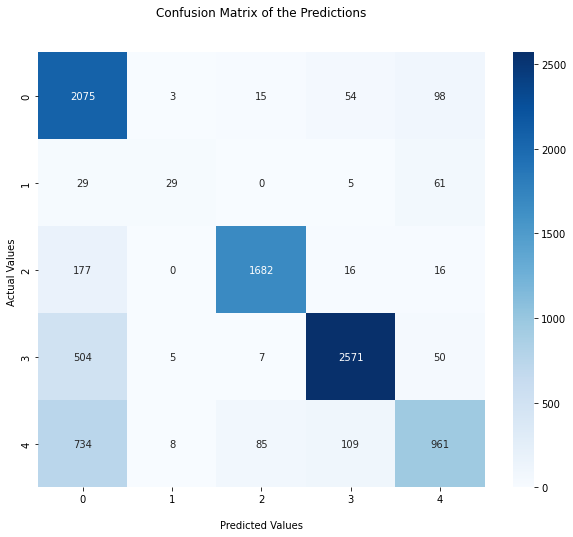

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.heatmap(confusion5, annot=True, cmap='Blues', fmt='d')
ax.set_title('Confusion Matrix of the Predictions\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1,2,3,4])
ax.yaxis.set_ticklabels([0,1,2,3,4])
## Save and display the visualization of the Confusion Matrix.
plt.savefig('output/svm5.png')
plt.show()

In [ ]:
data5 = pd.DataFrame(confusion5, index=np.unique(y_test5), columns=np.unique(y_test5))
data5.head()

,0,1,2,3,4
0,2075,3,15,54,98
1,29,29,0,5,61
2,177,0,1682,16,16
3,504,5,7,2571,50
4,734,8,85,109,961


In [ ]:
data5.to_csv('output/svm5.csv')

In [ ]:
print(f'Accuracy with 5 classes:{accuracy_score(y_test5.tolist(),y_pred5.tolist())}')
print("Weighted F1-Score with 5 classes: {}".format(f1_score(y_test5.tolist(), y_pred5.tolist(), average='weighted')))

Accuracy with 5 classes:0.7873897137938455
Weighted F1-Score with 5 classes: 0.7862985198931911
